# blink coordination
analysis of coordination in blink timing 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act # 
import respy_test as respy

Import data from one piece and translate to dataframe

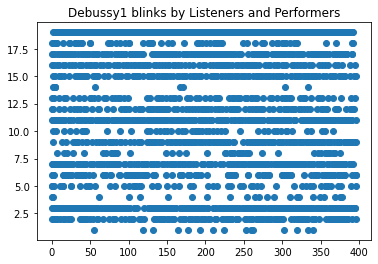

In [5]:
pieces = ['Debussy1','Debussy2','Haydn1','Haydn2']
workN = 0
work = pieces[workN]
os.chdir('./data')
f = work +'-fulldata.csv'
sig = pd.read_csv(f, header=None)
os.chdir('..')

x = sig[1]
y = sig[0]
plt.scatter(x,y)
plt.title(work + ' blinks by Listeners and Performers')
plt.show()


In [6]:
df_blinks = pd.DataFrame()
for i in range(20):
    sub_blinks = pd.DataFrame(index=sig.loc[sig[0]==i+1,1].values)
    sub_blinks[i] = 1
    df_blinks = df_blinks.append(sub_blinks,ignore_index=False)
df_blinks=df_blinks.fillna(0)
df_blinks = df_blinks.sort_index()

Using the activity analysis library, evaluate the alignment of blinks by all and by just listeners, ranging over a few sizes of synchrony windows. 

First is the question of whether there is a reasonable interval overwhich blinks can be counted as happening in alignment with the music. 

While blinks can be quite rapid in reaction to some stimuli, we expect aligned blinks to be reflecting a cognitive assessment of formal structure, marking boundaries in between phrases or sections. The kind of evaluation is much slower and fuzzier than protective reflexes, so we consider alignment as evaluated over intervals ranging from 0.1 to 0.9 seconds.

In [17]:
windows = np.arange(0.1,1.0,0.1)
windows

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

93.93883490562439
165.8639211654663
238.06098985671997
312.1503689289093
389.38032507896423
467.8795680999756
548.2321982383728
628.9691162109375
707.2692029476166


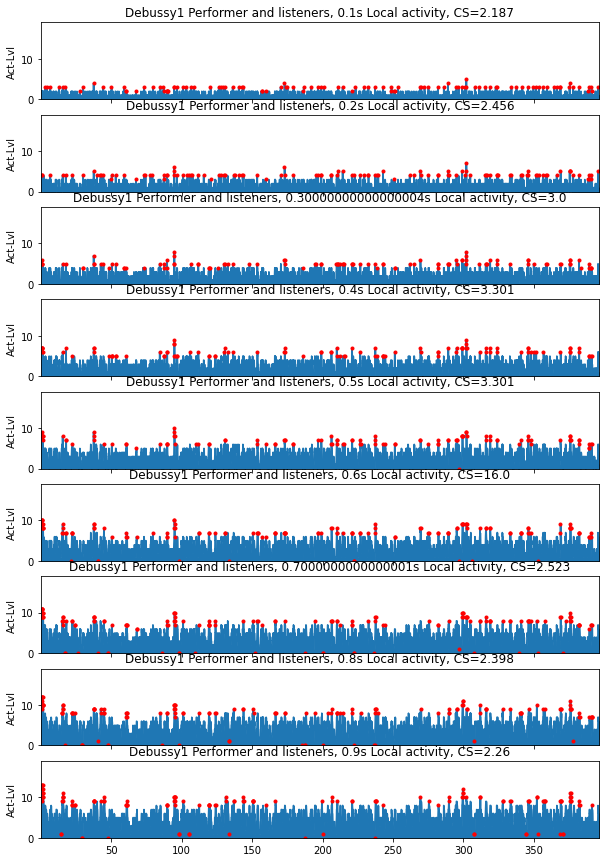

In [41]:
fig, axs = plt.subplots(9,1, sharex='all',figsize=(10,15))
tic = time.time()
FrameSize = 0.1
HopSize = 0.1
Thresh = 0.5
alpha = 0.01
actType = 'UBound'
ShuffleRange = 10
Iter = 2000
Acts=act.activityCount(df_blinks,FrameSize,HopSize,Thresh,actType)
Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
    
for j in range(len(windows)):
    FrameSize = windows[j]
    stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=axs[j])
    if C >=-np.log10(alpha):
        B['Activity-levels'].plot(style='r.',ax=axs[j])
    else:
        B['Activity-levels'].plot(style='y.',ax=axs[j])
    axs[j].set_ylim(0,19)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')

    axs[j].set_title(work + ' Performer and listeners, ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
    print(time.time()-tic)
    os.chdir('./peaks')
    stest['ActivityPeaks'].to_csv(work+'_PL_'+ str(FrameSize) + 's_peaks.csv')
    os.chdir('..')
os.chdir('./plots')
plt.savefig(work+'_0p1_L_P_blinks_aligned.png',dpi = 400)
os.chdir('..')
plt.show()




The coordination scores for the set of blinks by all 16 listeners and 4 performers are consistently above the alpha = 0.01 significiance threshold (CS = 2) for all windows of synchrony evaluated on this sample. The score is highest for 0.4 s (CS = 3.3) and 0.5 s (CS = 16, the highest value possible in this nonparameteric evaluation of OH THAT'S A MISTAKE IN THE CODE I SHOULD FIX, TO SET MIN P VALUES IN RELATION TO ITERATION NUMBER.)

The window of synchrony needs to be large enough to aggregate stimulus-coordinated reactions despite interparticipant differences in reaction time etc., but it also needs to be small enough to avoid accumulating a lot of unrelated action. The window that produces the highest coordination scores reports the distribution that is most easily distinguished from the coincidences of blinks we get without stimulus coordination. As such, 0.5 s seems like a good size, at least according to the blinking activity across 20 participants, including performers. 

Does this coordination show up in the listener only set of blinks?

65.4181580543518
131.56783294677734
198.64256620407104
266.4832167625427
334.94927883148193
404.865660905838
475.56069707870483
546.6787059307098
619.6968297958374


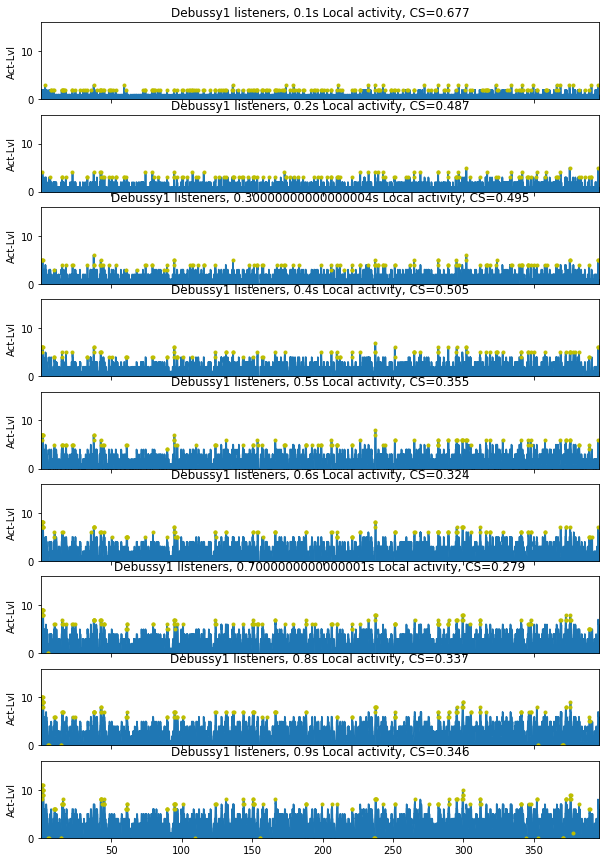

In [42]:
# only listeners
Data = Acts.loc[:,range(16)]
    
fig, axs = plt.subplots(9,1, sharex='all',figsize=(10,15))
tic = time.time()

for j in range(len(windows)):
    FrameSize = windows[j]
    stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=axs[j])
    if C >=-np.log10(alpha):
        B['Activity-levels'].plot(style='r.',ax=axs[j])
    else:
        B['Activity-levels'].plot(style='y.',ax=axs[j])
    axs[j].set_ylim(0,16)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')

    axs[j].set_title(work + ' listeners, ' + str(FrameSize) + 's Local activity, CS='+str(round(C,3)))
    print(time.time()-tic)
    os.chdir('./peaks')
    stest['ActivityPeaks'].to_csv(work+'_L_'+ str(FrameSize) + 's_peaks.csv')
    os.chdir('..')
os.chdir('./plots')
plt.savefig(work+'_0p1_L_blinks_aligned.png',dpi = 400)
os.chdir('..')
plt.show()

Looking at listeners alone, their alignment of blinks do not appear extraordinary, at least not in their unordered distributions of activity levels for this range of synchrony windows. This does not negate the possibility of this music having an effect on the timing of blinks for these listeners; if the music's influence on listener blinks is intermittent and rare, this influence cannot be detected without exogenous restrictions on when the effect may be seen.

It is reassuring to see the same most extreme peaks in the performer + listerner and the only-listener sets, (2, 95 ish). Attending to the numbers we see that while the performers were most consistent, the concentration of listeners blinking at that time exceeds the average noise. 

Given the distributions of concurrent blinks and the assess alignment by the local coordination test, it seems practical to focus on counting in range of 0.3-0.5 seconds, and to expect clearer coherence with the performers included in the analysis. 

Debussy1
120.19048595428467
238.9459090232849
357.84704995155334
477.5800859928131


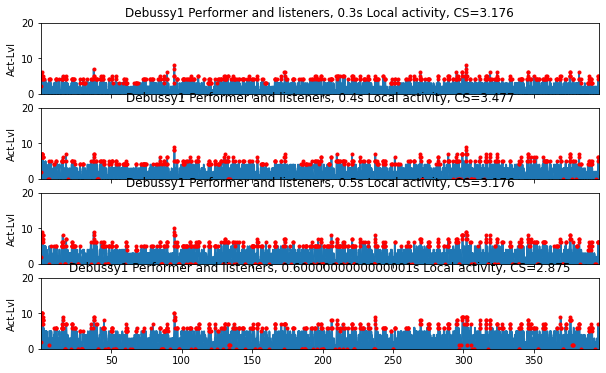

109.30069231987
223.76586818695068
336.8962812423706
8948.620243310928


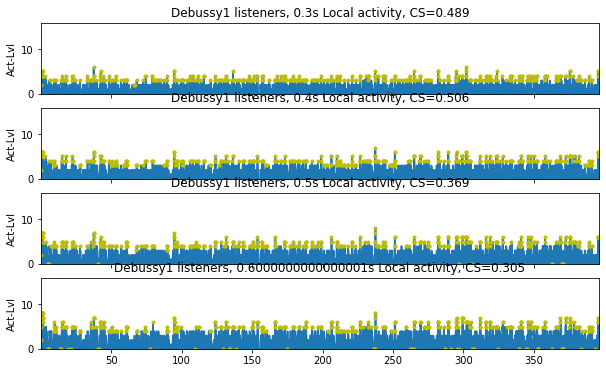

Debussy2
91.98102569580078
184.40971398353577
275.6184539794922
374.21953892707825


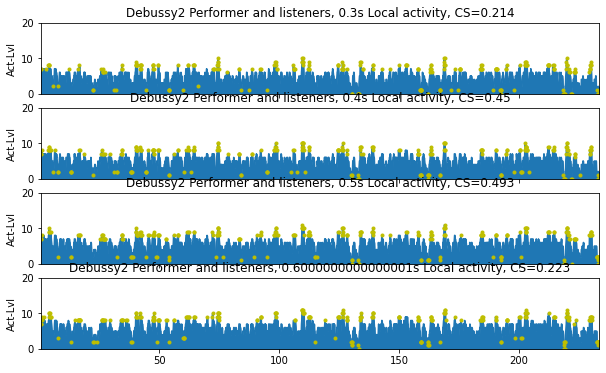

83.86521601676941
166.91841197013855
254.70919394493103
343.2877290248871


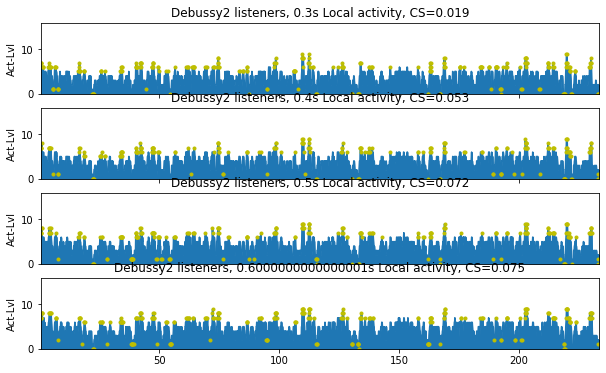

Haydn1
124.50318503379822
249.70514583587646
376.79787397384644
506.32612586021423


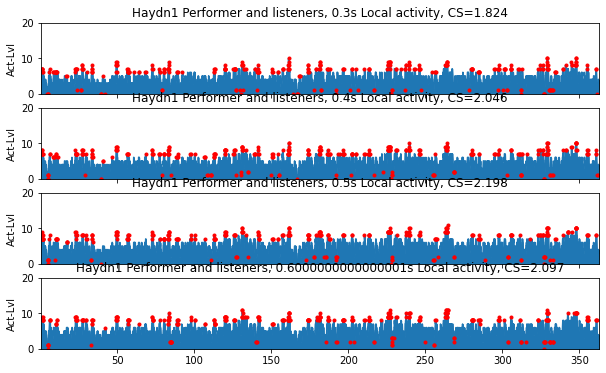

120.32206416130066
242.27485990524292
363.49617290496826
486.6355948448181


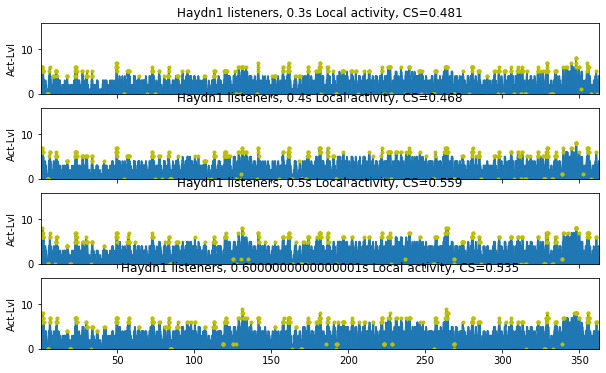

Haydn2
99.22641491889954
201.18412899971008
302.9127631187439
405.55515694618225


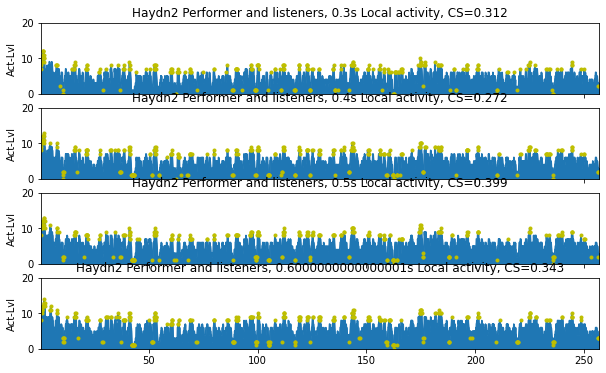

90.95826506614685
183.80260610580444
276.61556005477905
373.69306087493896


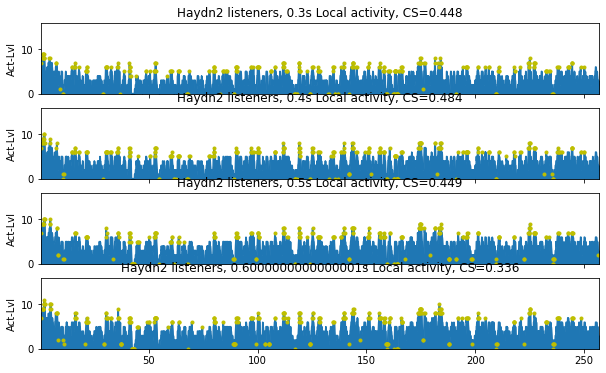

In [48]:
windows = np.arange(0.3,0.7,0.1)
tic = time.time()
FrameSize = 0.1
HopSize = 0.1
Thresh = 0.5
alpha = 0.05
actType = 'UBound'
ShuffleRange = 10
Iter = 3000

Data = Acts.drop(columns=['Total'])
for work in pieces:
    print(work)
    os.chdir('./data')
    f = work +'-fulldata.csv'
    sig = pd.read_csv(f, header=None)
    os.chdir('..')  
    
    df_blinks = pd.DataFrame()
    for i in range(20):
        sub_blinks = pd.DataFrame(index=sig.loc[sig[0]==i+1,1].values)
        sub_blinks[i] = 1
        df_blinks = df_blinks.append(sub_blinks,ignore_index=False)
    df_blinks=df_blinks.fillna(0)
    df_blinks = df_blinks.sort_index()

    Acts=act.activityCount(df_blinks,FrameSize,HopSize,Thresh,actType)
    Acts= Acts.fillna(0)
    
    # performer and listener blinks together
    Data = Acts.drop(columns=['Total'])
    fig, axs = plt.subplots(len(windows),1, sharex='all',figsize=(10,6))
    tic = time.time()
    for j in range(len(windows)):
        FrameSize = windows[j]
        stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
        A = stest['MeasuredResults']
        B = stest['ActivityPeaks']
        C = stest['CoordScore']
        # plot the activity levels with local activity peaks
        A['Activity-levels'].plot.area(ax=axs[j])
        if C >=-np.log10(alpha):
            B['Activity-levels'].plot(style='r.',ax=axs[j])
        else:
            B['Activity-levels'].plot(style='y.',ax=axs[j])
        axs[j].set_ylim(0,20)
        axs[j].set_xlim(A.index[0],A.index[-1])
        axs[j].set_ylabel('Act-Lvl')

        axs[j].set_title(work + ' Performer and listeners, ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
        print(time.time()-tic)
        os.chdir('./peaks')
        stest['ActivityPeaks'].to_csv(work+'_PL_'+ str(FrameSize) + 's_peaks.csv')
        os.chdir('..')
    os.chdir('./plots')
    plt.savefig(work+'_P_L_blinks_aligned.png',dpi = 400)
    os.chdir('..')
    plt.show()
    
    # just listeners
    Data = Acts.loc[:,range(16)]
    fig, axs = plt.subplots(len(windows),1, sharex='all',figsize=(10,6))
    tic = time.time()

    for j in range(len(windows)):
        FrameSize = windows[j]
        stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
        A = stest['MeasuredResults']
        B = stest['ActivityPeaks']
        C = stest['CoordScore']
        # plot the activity levels with local activity peaks
        A['Activity-levels'].plot.area(ax=axs[j])
        if C >=-np.log10(alpha):
            B['Activity-levels'].plot(style='r.',ax=axs[j])
        else:
            B['Activity-levels'].plot(style='y.',ax=axs[j])
        axs[j].set_ylim(0,16)
        axs[j].set_xlim(A.index[0],A.index[-1])
        axs[j].set_ylabel('Act-Lvl')

        axs[j].set_title(work + ' listeners, ' + str(FrameSize) + 's Local activity, CS='+str(round(C,3)))
        print(time.time()-tic)
        os.chdir('./peaks')
        stest['ActivityPeaks'].to_csv(work+'_L_'+ str(FrameSize) + 's_peaks.csv')
        os.chdir('..')
    os.chdir('./plots')
    plt.savefig(work+'_L_blinks_aligned.png',dpi = 400)
    os.chdir('..')
    plt.show()    

Is there stimulus coordinated blinking occuring?

Activity analysis identifies exceptional distributions of alignment in blinks across Listeners and Performers (set of 20) to the first Debussy work and the first Haydn work. The distinctive peaks in these larger sets are noticeable in the listener only sets, but these do not appear coordinated without exogenous reference points, e.g. if there is a coordinating effect of the music on the listeners' blinks, it is rare and not easily distinguished from noise. We can suppose then that the musicians are more likely to show music-aligned blinking over the course of a work, while listeners are generally less sensitive but may still be succeptible to stimulus-motivated blinking.

Next to consider is when there are peaks in alignment for the two pieces with significant coordination and compare these to formal qualities of the stimuli.